# 1. Importing Dependencies

In [35]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# 2. Loading the input image

In [36]:
image = cv2.imread("input.png")

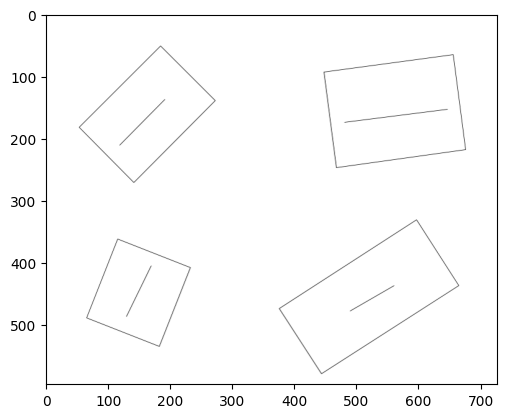

In [37]:
plt.imshow(image)

In [38]:
# Backing up the original image to drawing results later on
orig_image = image.copy()

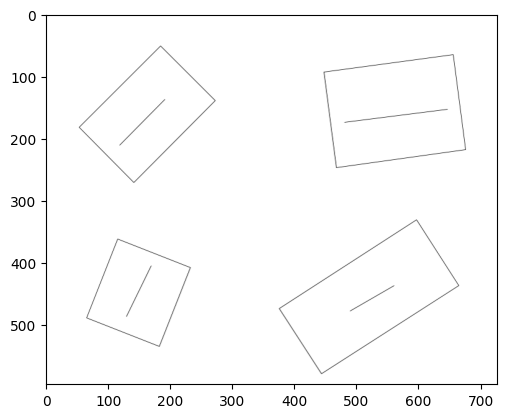

In [39]:
plt.imshow(orig_image)

# 3. Preprocessing

## a. Grayscale conversion

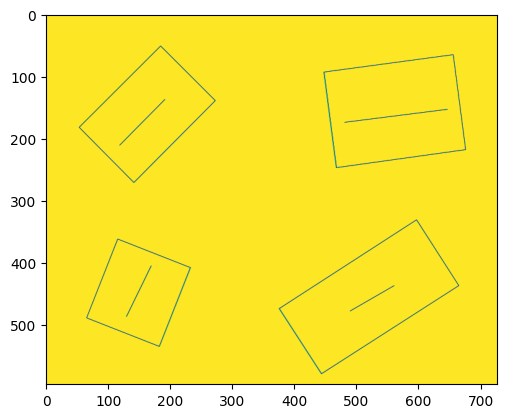

In [40]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)

## b. Applying Gaussian Blur

In [41]:
blur=cv2.GaussianBlur(gray,(5,5),0)

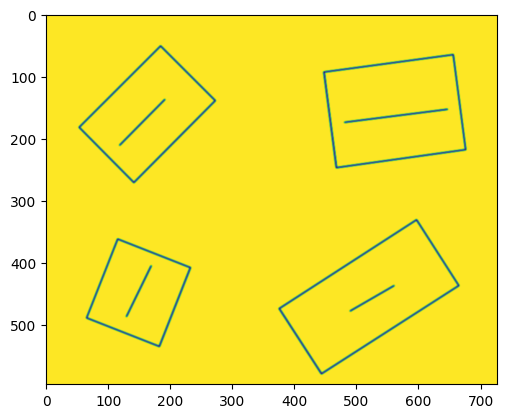

In [42]:
plt.imshow(blur)

## c. Edge detection using Canny edge detector

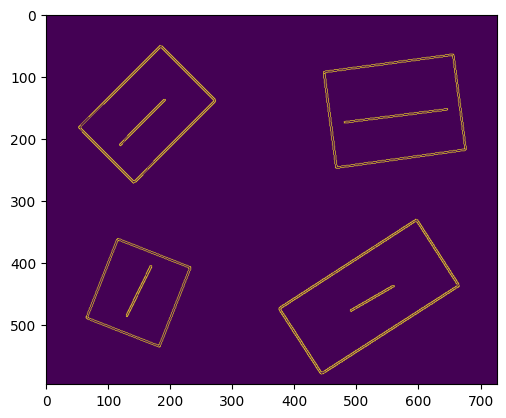

In [43]:
edges = cv2.Canny(blur, threshold1=50, threshold2=200)
plt.imshow(edges)

# 4. Find Rectangles (contour Detection)

In [44]:
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [45]:
rectangles=[] # empty list to store detected rectangles

In [46]:
# Loop through each detected contour
for cnt in contours:
    approx=cv2.approxPolyDP(cnt, 0.02*cv2.arcLength(cnt,True),True)
    if len(approx)==4 and cv2.contourArea(approx)>500:
        rectangles.append(approx)

# 5. For each rectangle, detect the longest internal line length

In [55]:
line_lengths = [] # will store tuples of  (rectangle_index, longest_line_length)
for i, rect in enumerate(rectangles):
    # Get bounding box of rectangle to extract its region of interest (ROI)
    x, y, w, h = cv2.boundingRect(rect) # cv2.boundingRect(rect) returns (x, y, width, height)
    # This helps us extract the region of interest (ROI) inside the rectangle on the grayscale image
    roi=gray[y:y+h,x:x+w] # Crop the rectangle area from the grayscale image

    # Detect edges inside the rectangle region using Canny edge detector
    # Canny helps find strong edges which are likely to correspond to lines in the rectangle
    edges_roi = cv2.Canny(roi, 50, 150)
    
    # Detect line segments in the edge image using Probabilistic Hough Line Transform
    lines = cv2.HoughLinesP(edges_roi, 1, np.pi/180, threshold=50, minLineLength=20, maxLineGap=5)
    
    max_length = 0  #Variable that Stores the longest line length found inside this iterating rectangle
    
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Calculate Euclidean distance between the two endpoints of the line segment
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            # Update max_length if current line is longer
            if length > max_length:
                max_length = length

    line_lengths.append((i, max_length))

In [56]:
line_lengths

[(0, np.float64(138.15932831336434)),
 (1, np.float64(263.2299375071156)),
 (2, np.float64(210.01190442448734)),
 (3, np.float64(188.09040379562165))]

# 6. Ranking rectangles based on their longest line lengths in ascending order

In [58]:
line_lengths.sort(key=lambda x: x[1]) # sort by length, shortest first 
# Here x[1] takes the distance value

In [59]:
line_lengths

[(0, np.float64(138.15932831336434)),
 (3, np.float64(188.09040379562165)),
 (2, np.float64(210.01190442448734)),
 (1, np.float64(263.2299375071156))]

In [62]:
rank = 1 #Starting the ranking from 1 because smallest line length will be ranked 1st

In [65]:
# Loop through each tuple inside line_lengths
# Each tuple looks like: (rectangle_index, longest_line_length)
for item in line_lengths:
    idx = item[0]  # Get the rectangles index from the tuple

    # Get the (x, y) position and width and height of the rectangle using its index
    x, y, w, h = cv2.boundingRect(rectangles[idx])

    # Draw the rank number as a text, below the rectangle in the original image
    cv2.putText(
        orig_image,       # Image to draw on
        str(rank),        # Rank is in int number and we need to convert to string
        (x + w // 2, y + h + 20),  # Position: horizontally centered, 20px below the rectangle
        cv2.FONT_HERSHEY_SIMPLEX,  # Font style
        1,                 # Font scale
        (0, 0, 0),         # Text color (black)
        2   # Thickness of the text
    )
    